# BONUS 3 - Conway's Game of Life

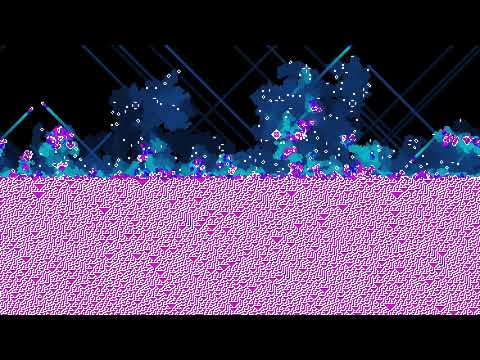

In [ ]:
# For fun, watch a few seconds of this video before starting the problem
from IPython.display import YouTubeVideo
YouTubeVideo('IK7nBOLYzdE')
# Credits to https://github.com/KyleBanks for parts of the code used

This Bonus problem will introduce you to the cellular automaton, Conway's Game of Life.

The universe of the Game of Life is an HxW, two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead. Every cell interacts with its eight neighbours, which are the cells that are horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

- Any live cell with two or three live neighbours survives.
- Any dead cell with three live neighbours becomes a live cell.
- All other live cells die in the next generation. Similarly, all other dead cells stay dead.

Edge cases are treated with wrap padding (toroidal topology). This allows the unrestricted transfer of state information across the boundaries.

The goal of this problem is to train a shallow CNN to predict the next step of a Game of Life frame. Note that we can craft a set of hand-written convolution kernels to solve the problem with 100% accuracy. This problem aims at figuring out if such CNN can be learned from data.

Switch to GPU runtime.

1.   Read the provided code. Run the two examples (random init and Glider gun). Explain what the `generate_dataset` does.

1.   Write the following CNN architecture, no need to use BN (fill in the '?')
```
3x3 conv C=32 padding=? - act=ReLU -> 1x1 conv C=16 - act=ReLU -> 1x1 conv C=? - act=?
```
Train it on the data for 3 epochs using BS=32, adam with default LR, and an appropriate loss function, you should get around 97~98 validation accuracy, you can use `validation_split=0.1` in the fit method.

2.   Use the trained model to predict on the dev split. Show where the model is making mistakes by averaging the error frames (you can plot using `imshow`)

3.   Explain why these errors happen 

4.   Write the function `wrap_pad(input, size)` which performs wrap padding. Note that the function should take an input of shape (N,H,W,C) and perform the padding in H and W, leaving N and C untouched. **It is important to use only tf functions, Hint: use tf.concat together with some tensor slicing.** (otherwise you need to wrap it in tf.py_function).
 
```python
test = tf.constant([[1, 2, 3],[4, 5, 6],[7, 8, 9]])
test = tf.reshape(test,shape=(1,3,3,1)) #(N,H,W,C)
wrap_pad(test, 1)[0,:,:,0]
[[9, 7, 8, 9, 7],
 [3, 1, 2, 3, 1],
 [6, 4, 5, 6, 4],
 [9, 7, 8, 9, 7],
 [3, 1, 2, 3, 1]]
```

6.   Use the functional API to define an architecture similar to 1. but using the wrap_pad function before the 3x3 conv layer.

7.   Train using same hyperparameters as in 1. and comment.

**Note**

If you liked this problem, and are interested in cellular automata. Stephen Wolfram is currently hosting a (math oriented) research competition around cellular automata, with monetary prizes. This could be a good research project! 

More here:

https://www.rule30prize.org/

https://writings.stephenwolfram.com/2019/10/announcing-the-rule-30-prizes/

In [ ]:
import numpy as np
import tensorflow as tf
import time
from IPython.display import display, clear_output
from tensorflow.keras.layers import Conv2D
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
class ConwaysGameOfLife:

  def __init__(self, num_samples, width, height, probability_for_life=0.15, initial_frames=None):

    if initial_frames is None:
      self.width = width
      self.height = height
      self.num_samples = num_samples
      self.grid = np.array([
                  np.random.choice([False, True], size=(height, width), p=[1-probability_for_life, probability_for_life])
                  for _ in range(num_samples)]).astype(int)
    else:
      self.num_samples , self.height, self.width = initial_frames.shape
      self.grid = initial_frames
  
  def life_step_sample(self, frame):
    live_neighbors = sum(np.roll(np.roll(frame, i, 0), j, 1)
                      for i in (-1, 0, 1) for j in (-1, 0, 1)
                      if (i != 0 or j != 0))
    return (live_neighbors == 3) | (frame & (live_neighbors == 2)).astype(int)  
  
  def life_step(self):
    X = np.zeros_like(self.grid)
    for idx in range(self.num_samples):
      X[idx] = self.life_step_sample(self.grid[idx,:,:])
    self.grid = X

  def plot(self, idx, **kwargs):
    fig, ax = plt.subplots()
    ax.imshow(self.grid[idx,:,:], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])    
    display(fig)

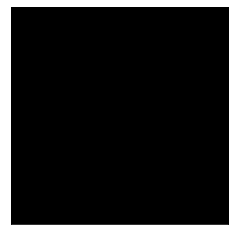

In [ ]:
# Random init
automata = ConwaysGameOfLife(1, 16, 16)
for _ in range(10):
  clear_output(wait=True)
  automata.plot(idx=0)
  time.sleep(0.8)
  plt.close()
  automata.life_step()

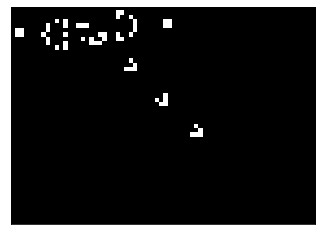

In [ ]:
# The glider gun
glider_gun =\
[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]

X = np.zeros((1, 50, 70))
X[:, 1:10,1:37] = glider_gun
automata = ConwaysGameOfLife(1, 50, 70, initial_frames=X.astype(int))
for _ in range(100):
  clear_output(wait=True)
  automata.plot(idx=0)
  time.sleep(0.2)
  plt.close()
  automata.life_step()

In [ ]:
IMG_SIZE = (16,16)
NUM_SAMPLES = 30000

def generate_dataset(NUM_SAMPLES, IMG_SIZE):
  automata = ConwaysGameOfLife(NUM_SAMPLES, IMG_SIZE[0],IMG_SIZE[1])
  X = automata.grid
  automata.life_step()
  Y = automata.grid
  return X[:,:,:,None], Y[:,:,:,None]

# 1.
# COMMENT ON THE CODE PROVIDED

In [ ]:
X, Y = generate_dataset(NUM_SAMPLES, IMG_SIZE) # Takes a few seconds
X_dev, Y_dev = generate_dataset(100, IMG_SIZE)

In [ ]:
# 2.
# YOUR CODE HERE
# model = tf.keras.models.Sequential()
# 
# 
# model.compile
# model.fit

In [ ]:
# 3.
# YOUR CODE HERE
#
#
# plt.show()

# 4.
# YOUR COMMENT HERE

In [ ]:
# 5.
def wrap_pad(input, size):
    # YOUR CODE HERE
    #
    return 

# TEST CASE
test = tf.constant([[1, 2, 3],[4, 5, 6],[7, 8, 9]])
test = tf.reshape(test,shape=(1,3,3,1))
wrap_pad(test, 1)[0,:,:,0]

In [ ]:
# 6.
# YOUR CODE HERE
# input = tf.keras.Input(shape=IMG_SIZE+(1,))
# 
#
# 
# model_wrap = tf.keras.Model(...)
# model_wrap.compile
# 7.
# model_wrap.fit 
# 